# Python Interface
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import (
    NSGA2Generator,
    PolynomialMutation,
    SimulatedBinaryCrossover,
)
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator, VOCS

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",  # Format for log messages
    datefmt="%Y-%m-%d %H:%M:%S",  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(
        pm=1 / 30, eta_m=20
    ),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(
        delta_1=0.5, delta_2=0.5, eta_c=20
    ),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-08-27 00:07:59 - xopt.generator - INFO - Initialized generator nsga2


2025-08-27 00:07:59 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-08-27 00:07:59 - xopt.base - INFO - Running Xopt step


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - generated 50 candidates in 3.10ms (removed 0 duplicate individuals)


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - adding 50 new evaluated individuals to generator


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - completed generation 1 in 0.048s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)


2025-08-27 00:07:59 - xopt.base - INFO - Running Xopt step


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - generated 50 candidates in 16.83ms (removed 0 duplicate individuals)


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - adding 50 new evaluated individuals to generator


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - completed generation 2 in 0.031s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=100, n_candidates=100)


2025-08-27 00:07:59 - xopt.base - INFO - Running Xopt step


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - generated 50 candidates in 16.71ms (removed 0 duplicate individuals)


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - adding 50 new evaluated individuals to generator


2025-08-27 00:07:59 - xopt.generators.ga.nsga2.NSGA2Generator.140428405041792 - INFO - completed generation 3 in 0.030s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=150, n_candidates=150)


### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: user 1.36 s, sys: 3.14 ms, total: 1.36 s
Wall time: 1.36 s


In [7]:
# Inspect generator properties
print(
    f"Saw {generator.fevals} function evaluations"
)  # Number of function evaluations returned to generator
print(
    f"Completed {generator.n_generations} generations"
)  # Number of generations finished
print(
    f"Generated {generator.n_candidates} candidate solutions"
)  # Number of individuals generated

Saw 0 function evaluations
Completed 0 generations
Generated 0 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a
# unique index for indviduals.
#
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
X.generator.data.head()

x1       x10       x11       x12       x13       x14       x15  \
0  0.012013  0.307963  0.520922  0.777506  0.695134  0.259388  0.218282   
1  0.026010  0.646421  0.980483  0.569927  0.300956  0.986732  0.807409   
2  0.036130  0.942081  0.656600  0.141044  0.147971  0.347431  0.291623   
3  0.061625  0.868299  0.965816  0.854591  0.190402  0.763122  0.381275   
4  0.071282  0.852120  0.453507  0.410709  0.536522  0.987442  0.417369   

        x16       x17       x18  ...        x7        x8        x9  \
0  0.644081  0.473104  0.260611  ...  0.035945  0.607859  0.103189   
1  0.509344  0.327639  0.223998  ...  0.518256  0.022526  0.550170   
2  0.164811  0.307275  0.900056  ...  0.963907  0.317184  0.629440   
3  0.618793  0.548545  0.206911  ...  0.502427  0.747496  0.887666   
4  0.268784  0.319221  0.256244  ...  0.477990  0.778891  0.292708   

   xopt_parent_generation  xopt_candidate_idx        f1        f2         g  \
0                       0                  13  0.012013  4.754328  5.003934   
1                       0                  30  0.026010  4.502153  4.877289   
2                       0                   9  0.036130  5.183371  5.668686   
3                       0                   6  0.061625  5.592811  6.272079   
4                       0                  32  0.071282  5.012323  5.706018   

   xopt_runtime  xopt_error  
0      0.000047       False  
1      0.000020       False  
2      0.000016       False  
3      0.000013       False  
4      0.000017       False  

[5 rows x 37 columns]

In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(X.generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
X.generator.data[
    X.generator.data["xopt_candidate_idx"].isin(X.generator.history_idx[0])
].head()

[2467, 2435, 2419, 2473, 2406, 2404, 2447, 2353, 2327, 2472, 2250, 2413, 2484, 2302, 2409, 2464]


x1       x10       x11       x12       x13       x14       x15  \
0  0.012013  0.307963  0.520922  0.777506  0.695134  0.259388  0.218282   
1  0.026010  0.646421  0.980483  0.569927  0.300956  0.986732  0.807409   
2  0.036130  0.942081  0.656600  0.141044  0.147971  0.347431  0.291623   
3  0.061625  0.868299  0.965816  0.854591  0.190402  0.763122  0.381275   
4  0.071282  0.852120  0.453507  0.410709  0.536522  0.987442  0.417369   

        x16       x17       x18  ...        x7        x8        x9  \
0  0.644081  0.473104  0.260611  ...  0.035945  0.607859  0.103189   
1  0.509344  0.327639  0.223998  ...  0.518256  0.022526  0.550170   
2  0.164811  0.307275  0.900056  ...  0.963907  0.317184  0.629440   
3  0.618793  0.548545  0.206911  ...  0.502427  0.747496  0.887666   
4  0.268784  0.319221  0.256244  ...  0.477990  0.778891  0.292708   

   xopt_parent_generation  xopt_candidate_idx        f1        f2         g  \
0                       0                  13  0.012013  4.754328  5.003934   
1                       0                  30  0.026010  4.502153  4.877289   
2                       0                   9  0.036130  5.183371  5.668686   
3                       0                   6  0.061625  5.592811  6.272079   
4                       0                  32  0.071282  5.012323  5.706018   

   xopt_runtime  xopt_error  
0      0.000047       False  
1      0.000020       False  
2      0.000016       False  
3      0.000013       False  
4      0.000017       False  

[5 rows x 37 columns]

Text(0.5, 1.0, 'ZDT3, Generation 50')

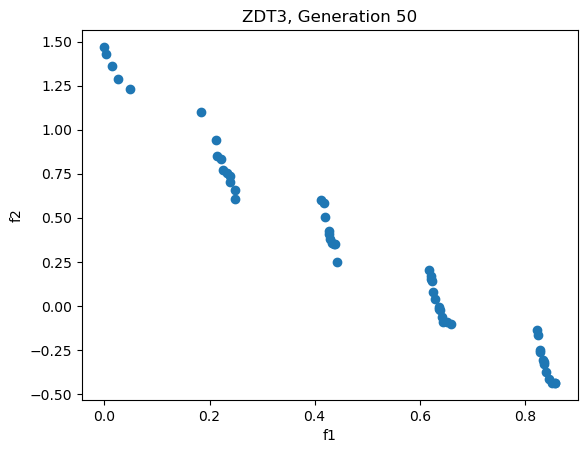

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = X.generator.data[
    X.generator.data["xopt_candidate_idx"].isin(X.generator.history_idx[-1])
]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {X.generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `vocs.txt`: The VOCS object so that the objectives, constraints, decision variables are retained alongside the data
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory
 - `log.txt`: Log output from the generator is recorded to this file

 Wile running each of the blocks, go ahead and open the temporary directory printed from the next cell and take a look at the files for yourself.

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f'Will write data to "{output_dir}"')

Will write data to "/tmp/tmpi2r5apv6"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # Turn on checkpoints and set how often (in terms of generations) we save the optimizer state
    log_level=logging.DEBUG,  # Set the level of log messages output to our log file
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f'"{output_dir}": {os.listdir(output_dir)}')
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f'"checkpoints": {os.listdir(checkpoint_dir)}')

"/tmp/tmpi2r5apv6": ['log.txt', 'populations.csv', 'checkpoints', 'data.csv', 'vocs.txt']
"checkpoints": ['20250827_000803_1.txt', '20250827_000801_1.txt', '20250827_000802_1.txt', '20250827_000801_2.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(
    generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir),
    evaluator=ev,
    vocs=prob_vocs,
)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f'Requested path: "{output_dir}"')
print(f'Path used:      "{X.generator.output_dir}"')

# Clean up the directory
X.generator.close_log_file()

Requested path: "/tmp/tmpi2r5apv6"
Path used:      "/tmp/tmpi2r5apv6_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(X.generator.output_dir, "data.csv"))
df.head()

x1       x10       x11       x12       x13       x14       x15  \
0  0.009831  0.097018  0.825678  0.434224  0.418010  0.070635  0.574515   
1  0.029717  0.046462  0.712950  0.106684  0.847739  0.953609  0.340874   
2  0.030487  0.189546  0.324647  0.439414  0.056999  0.004462  0.638347   
3  0.039259  0.399676  0.726830  0.102632  0.316435  0.188790  0.307090   
4  0.040843  0.269426  0.284116  0.612207  0.756510  0.244251  0.471837   

        x16       x17       x18  ...        x7        x8        x9  \
0  0.028031  0.572454  0.951590  ...  0.173640  0.671740  0.729109   
1  0.457058  0.643626  0.050303  ...  0.962431  0.895552  0.919151   
2  0.094315  0.973750  0.170075  ...  0.623195  0.010484  0.487473   
3  0.849366  0.864061  0.651914  ...  0.164063  0.895570  0.813934   
4  0.170068  0.567105  0.647610  ...  0.949863  0.400152  0.458763   

   xopt_parent_generation  xopt_candidate_idx        f1        f2         g  \
0                       0                  21  0.009831  4.857343  5.083888   
1                       0                  36  0.029717  5.260629  5.695933   
2                       0                  23  0.030487  4.827437  5.252539   
3                       0                  45  0.039259  4.588597  5.071865   
4                       0                  20  0.040843  5.603127  6.143200   

   xopt_runtime  xopt_error  
0      0.000035       False  
1      0.000016       False  
2      0.000014       False  
3      0.000012       False  
4      0.000012       False  

[5 rows x 37 columns]

In [16]:
# Read the VOCS object back in. This can be used for data analysis / restarting optimizations
with open(os.path.join(X.generator.output_dir, "vocs.txt")) as f:
    vocs_from_file = VOCS.from_dict(json.load(f))

# Show the objectives
vocs_from_file.objectives

{'f1': 'MINIMIZE', 'f2': 'MINIMIZE'}

In [17]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(X.generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

x1       x10       x11       x12       x13       x14       x15  \
1550  0.416141  0.014440  0.357001  0.090624  0.075059  0.171340  0.147563   
1551  0.003485  0.005270  0.204614  0.089790  0.073388  0.172147  0.147241   
1552  0.619014  0.008126  0.203284  0.008101  0.004152  0.171908  0.146988   
1553  0.068499  0.017726  0.201730  0.093534  0.028967  0.184964  0.129904   
1554  0.019832  0.017803  0.368061  0.007774  0.004886  0.178241  0.147018   

           x16       x17       x18  ...        x6        x7        x8  \
1550  0.030683  0.001249  0.014569  ...  0.082274  0.026046  0.012955   
1551  0.047673  0.017289  0.020888  ...  0.080094  0.026986  0.013451   
1552  0.299170  0.000109  0.050638  ...  0.045701  0.037109  0.008847   
1553  0.299257  0.038356  0.008717  ...  0.007780  0.027004  0.008804   
1554  0.303099  0.011050  0.010025  ...  0.002651  0.025363  0.009270   

            x9        f1        f2  xopt_generation  xopt_candidate_idx  \
1550  0.229679  0.416141  0.844097               32                1579   
1551  0.236273  0.003485  2.010726               32                1558   
1552  0.229782  0.619014  0.466088               32                1518   
1553  0.295477  0.068499  1.661799               32                1389   
1554  0.229462  0.019832  1.800323               32                1428   

      xopt_runtime  xopt_error  
1550      0.000011       False  
1551      0.000012       False  
1552      0.000011       False  
1553      0.000012       False  
1554      0.000011       False  

[5 rows x 36 columns]

In [18]:
# Reload the optimizer from its last checkpoint
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
restored_generator = NSGA2Generator(checkpoint_file=last_checkpoint)

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

# Clean up the output
X.generator.close_log_file()
shutil.rmtree(X.generator.output_dir)

Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=16, fevals=800)


In [19]:
# Clean up the original output
X.generator.close_log_file()

In [20]:
shutil.rmtree(output_dir)